In [30]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 200)
np.random.seed(42)


In [31]:
DATA_PATH = "../data/processed/bank_marketing_raw.csv"  # chỉnh path nếu cần

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(45211, 21)


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,poutcome_missing,target,pdays_contacted,has_previous_campaign
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,no_previous_campaign,no,1,0,1,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,no_previous_campaign,no,1,0,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,no_previous_campaign,no,1,0,1,0
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,no_previous_campaign,no,1,0,1,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,no_previous_campaign,no,1,0,1,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    45211 non-null  int64 
 1   job                    44923 non-null  object
 2   marital                45211 non-null  object
 3   education              43354 non-null  object
 4   default                45211 non-null  object
 5   balance                45211 non-null  int64 
 6   housing                45211 non-null  object
 7   loan                   45211 non-null  object
 8   contact                32191 non-null  object
 9   day_of_week            45211 non-null  int64 
 10  month                  45211 non-null  object
 11  duration               45211 non-null  int64 
 12  campaign               45211 non-null  int64 
 13  pdays                  45211 non-null  int64 
 14  previous               45211 non-null  int64 
 15  poutcome           

In [32]:
df["target"].value_counts(dropna=False)


target
0    39922
1     5289
Name: count, dtype: int64

In [34]:
TARGET = "target"

# PRE-CALL features (safe for targeting decision)
PRE_CALL_FEATURES = [
    "age", "job", "marital", "education",
    "default", "housing", "loan",
]

# OPTIONAL: include balance if you're using the older 'bank.csv' version; bank-additional-full does not have 'balance'
if "balance" in df.columns:
    PRE_CALL_FEATURES.insert(5, "balance")

# POST-CALL / campaign outcome / leakage features (DO NOT use for segmentation targeting)
POST_CALL_FEATURES = [c for c in [
    "contact", "month", "day_of_week", "duration",
    "campaign", "pdays", "previous", "poutcome"
] if c in df.columns]

print("Pre-call:", PRE_CALL_FEATURES)
print("Post-call:", POST_CALL_FEATURES)

df[PRE_CALL_FEATURES + [TARGET]].head()


Pre-call: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan']
Post-call: ['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


,age,job,marital,education,default,balance,housing,loan,target
0,58,management,married,tertiary,no,2143,yes,no,0
1,44,technician,single,secondary,no,29,yes,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,0
3,47,blue-collar,married,NaN,no,1506,yes,no,0
4,33,NaN,single,NaN,no,1,no,no,0


In [35]:
df[TARGET].value_counts(dropna=False)

target
0    39922
1     5289
Name: count, dtype: int64

EDA

In [36]:
overall_conv = df[TARGET].mean()
print(f"Overall conversion (y=yes): {overall_conv:.3f}")

missing = df[PRE_CALL_FEATURES].isna().mean().sort_values(ascending=False)
missing[missing > 0]


Overall conversion (y=yes): 0.117


education    0.041074
job          0.006370
dtype: float64

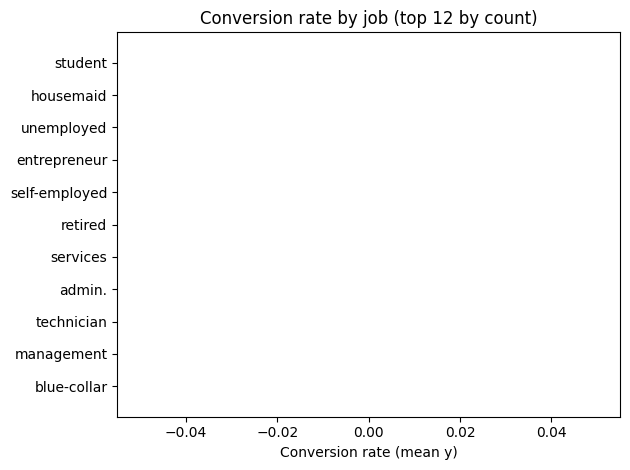

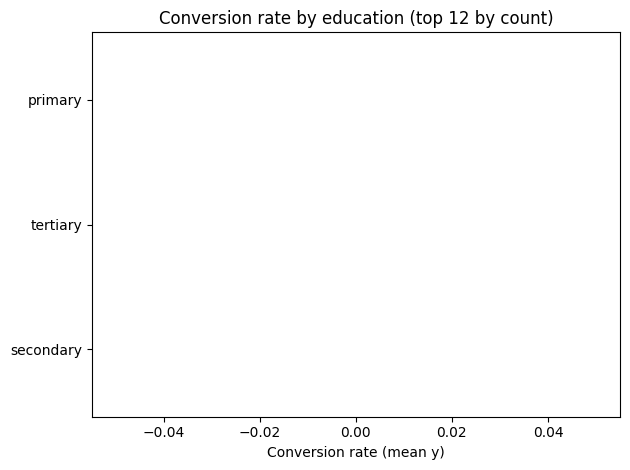

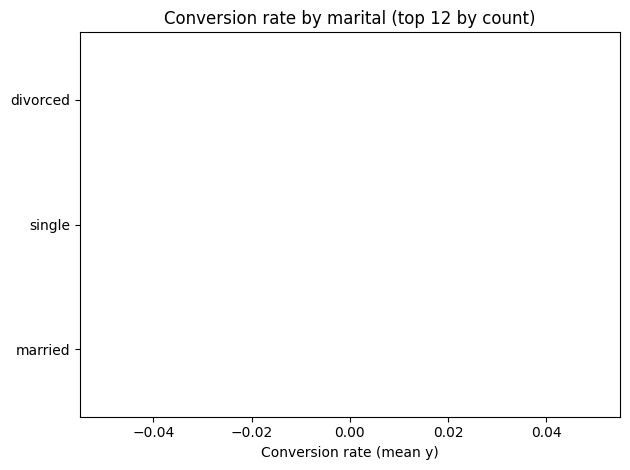

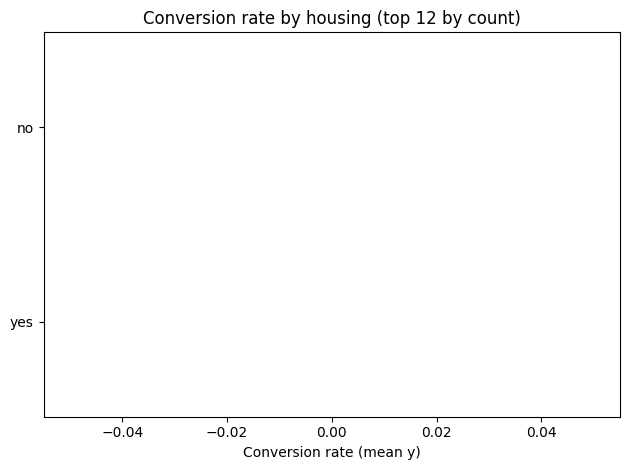

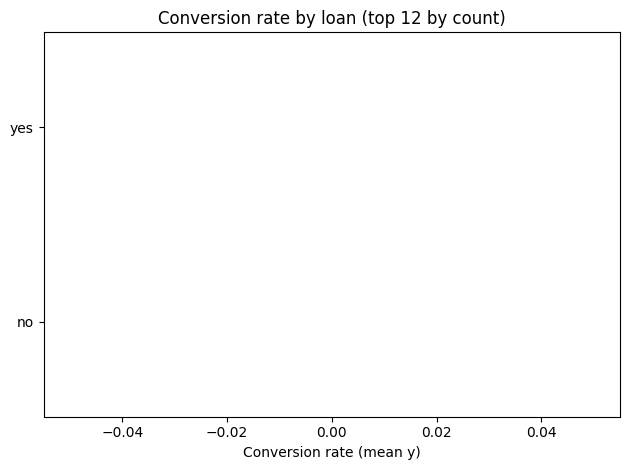

In [8]:
def plot_conversion_by_cat(data, col, target=TARGET, top_n=12):
    tmp = (data.groupby(col)[target]
           .agg(["mean", "count"])
           .sort_values("count", ascending=False)
           .head(top_n))
    tmp = tmp.sort_values("mean", ascending=True)
    plt.figure()
    plt.barh(tmp.index.astype(str), tmp["mean"])
    plt.title(f"Conversion rate by {col} (top {top_n} by count)")
    plt.xlabel("Conversion rate (mean y)")
    plt.tight_layout()
    plt.show()

for col in ["job", "education", "marital", "housing", "loan"]:
    if col in df.columns:
        plot_conversion_by_cat(df, col)


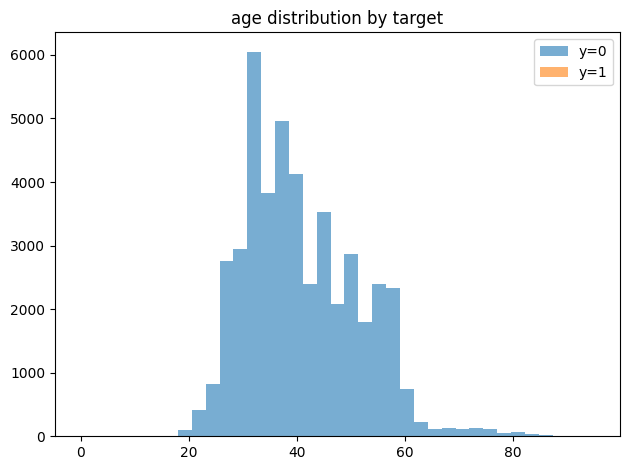

In [9]:
def plot_hist_by_target(data, col, target=TARGET, bins=30):
    plt.figure()
    plt.hist(data.loc[data[target]==0, col].dropna(), bins=bins, alpha=0.6, label="y=0")
    plt.hist(data.loc[data[target]==1, col].dropna(), bins=bins, alpha=0.6, label="y=1")
    plt.title(f"{col} distribution by target")
    plt.legend()
    plt.tight_layout()
    plt.show()

if "age" in df.columns:
    plot_hist_by_target(df, "age")


In [10]:
X = df[PRE_CALL_FEATURES].copy()
y = df[TARGET].copy()

num_features = [c for c in PRE_CALL_FEATURES if pd.api.types.is_numeric_dtype(df[c])]
cat_features = [c for c in PRE_CALL_FEATURES if c not in num_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

clf = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    n_jobs=None
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", clf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)
p_test = pipe.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, p_test))
print("PR-AUC :", average_precision_score(y_test, p_test))


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0